In [1]:
import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch 
import torch.nn as nn
import torch.optim
from torchvision import transforms
import torchvision.transforms as transform
from torchvision.utils import save_image
import torch.functional as F
import PIL
import torch.utils.data as data
import glob
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


DATA_FOLDER = '/content/drive/MyDrive/ml/data/'
TRAIN_FOLDER = DATA_FOLDER + 'training/training/'
GROUNDTRUTH_FOLDER = TRAIN_FOLDER + '/groundtruth/'
TRAIN_IMAGES = TRAIN_FOLDER + 'images/'
TEST_IMAGES = DATA_FOLDER + 'test_set_images/test_set_images/'
AUGMENTED_FOLDER = DATA_FOLDER + 'augmented/'
AUGMENTED_IMAGES = DATA_FOLDER + 'augmented/images/'
AUGMENTED_GT = DATA_FOLDER + 'augmented/labels/'


unet_pretrained_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [2]:

#This dataloder allows to import the immages on by one, only the directories are in the RAM
class DataLoaderSegmentation(data.Dataset):
    #Initalize the dataloader. Instead of having all the pics in ram we only save the directories.
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.folder_path = folder_path
        self.currentidx = 0
        self.img_files = glob.glob(os.path.join(folder_path,'images/','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path))) 
    #Return only the pic,label at specified index. The returned object is a torch tensor [channels,H,W]
    def __getitem__(self, index):
        if index >= len(self):
          index = (index%len(self))
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = transform.functional.pil_to_tensor(PIL.Image.open(img_path)).type(torch.FloatTensor)/255
        label =transform.functional.pil_to_tensor(PIL.Image.open(mask_path))[:1,:,:].type(torch.FloatTensor)/255
        return (data,label)
    def __len__(self):
        return len(self.img_files)
    #Return a batch of size batch_size of pic,label from hte currentidx to currentidx + batch_size.
    #The returned object is a torch tensor [batch_size,channels,H,W]
    def next(self,batch_size = 1):
        if batch_size == 1:
          self.currentidx += batch_size
          return self[self.currentidx-1]
        else:
          seq = [self[self.currentidx+i] for i in range(batch_size)]
          self.currentidx += batch_size
          imgs = [i[0] for i in seq]
          lbls = [i[1] for i in seq]
          
          res = (torch.stack(imgs),torch.stack(lbls))
          return res

    def get_epoch(self):
      return int(self.currentidx/len(self.img_files))

    def split_train_test( self,seed = 1 ,test_portion = 0.2):

      folder_path = self.folder_path

      test_set = DataLoaderSegmentation(folder_path)
      train_set = DataLoaderSegmentation(folder_path)

      copy_img_files = self.img_files
      copy_mask_files = self.mask_files

      index_array = list(range(len(copy_img_files)))
      random.Random(seed).shuffle(index_array)
     
      copy_img_files =  list(map(copy_img_files.__getitem__, index_array))
      copy_mask_files = list(map(copy_mask_files.__getitem__, index_array))

      quantity_test = int(len(copy_img_files)*test_portion)

      test_set.img_files = copy_img_files[:quantity_test]
      test_set.mask_files = copy_mask_files[:quantity_test]
      
      train_set.img_files = copy_img_files[quantity_test:]
      train_set.mask_files = copy_mask_files[quantity_test:]
      return train_set,test_set


In [3]:
#Function that allows to augment the data in a customized fashion.
dataset = DataLoaderSegmentation(folder_path = AUGMENTED_FOLDER)
#img,label = dataset.next(batch_size= 1)
#print(label.shape)
#img,label = dataset.next(batch_size=4)
#print(label.shape)
#dataset.currentidx = 1
#print(img.max())
#print(label.max())
train_set,test_set = dataset.split_train_test()
#img,label = train_set.next(batch_size= 1)
#print(label.max())

In [4]:
class Unet(nn.Module):
  def __init__(self,unet,add_dropouts = False):
    super().__init__()
    self.encoder1 = unet.encoder1
    self.pool1 = unet.pool1
    self.encoder2 = unet.encoder2
    self.pool2 = unet.pool2
    self.encoder3 = unet.encoder3
    self.pool3 = unet.pool3
    self.encoder4 = unet.encoder4
    self.pool4 = unet.pool4

    self.bottleneck = unet.bottleneck
    
    self.upconv4 = unet.upconv4
    self.decoder4 = unet.decoder4
    self.upconv3 = unet.upconv3
    self.decoder3 = unet.decoder3
    self.upconv2 = unet.upconv2
    self.decoder2 = unet.decoder2
    self.upconv1 = unet.upconv1
    self.decoder1 = unet.decoder1

    self.conv = unet.conv

  def add_dropout_encoder(probability , encoder):
    children = list(encoder.children())
    conv2d_1 = children[0]
    bn_1 = children[1]
    relu_1 = children[2]
    conv2d_2 = children[3]
    bn_2 = children[4]
    relu_2 = children[5]
    dropout = nn.Dropout2d(p = probability)
    return nn.Sequential(dropout,conv2d_1,bn_1,relu_1,dropout,conv2d_2,bn_2,relu_2)

  def forward(self, x):

    e1 = self.encoder1(x)

    e2 = self.encoder2(self.pool1(e1))

    e3 = self.encoder3(self.pool2(e2))

    e4 = self.encoder4(self.pool3(e3))

    bneck = self.bottleneck(self.pool4(e4))

    d4 = self.upconv4(bneck)
    d4 = torch.cat((d4,e4),dim = 1)
    d4 = self.decoder4(d4)

    d3 = self.upconv3(d4)
    d3 = torch.cat((d3,e3),dim = 1)
    d3 = self.decoder3(d3)

    d2 = self.upconv2(d3)
    d2 = torch.cat((d2,e2),dim = 1)
    d2 = self.decoder2(d2)

    d1 = self.upconv1(d2)
    d1 = torch.cat((d1,e1),dim = 1)
    d1 = self.decoder1(d1)

    res = torch.sigmoid(self.conv(d1))

    return res

class Unet_with_aux_loss(nn.Module):
  def __init__(self,unet,add_dropouts = False):
    super().__init__()
    self.encoder1 = unet.encoder1
    self.pool1 = unet.pool1
    self.encoder2 = unet.encoder2
    self.pool2 = unet.pool2
    self.encoder3 = unet.encoder3
    self.pool3 = unet.pool3
    self.encoder4 = unet.encoder4
    self.pool4 = unet.pool4

    self.bottleneck = unet.bottleneck
    
    self.upconv4 = unet.upconv4
    self.decoder4 = unet.decoder4
    self.upconv3 = unet.upconv3
    self.decoder3 = unet.decoder3
    self.upconv2 = unet.upconv2
    self.decoder2 = unet.decoder2
    self.upconv1 = unet.upconv1
    self.decoder1 = unet.decoder1

    self.conv = unet.conv
    self.poolLayer = nn.AvgPool2d(kernel_size = (16,16), stride= (16,16), ceil_mode = False)

  # def add_dropout_encoder(probability , encoder):
  #   children = list(encoder.children())
  #   conv2d_1 = children[0]
  #   bn_1 = children[1]
  #   relu_1 = children[2]
  #   conv2d_2 = children[3]
  #   bn_2 = children[4]
  #   relu_2 = children[5]
  #   dropout = nn.Dropout2d(p = probability)
  #   return nn.Sequential(dropout,conv2d_1,bn_1,relu_1,dropout,conv2d_2,bn_2,relu_2)

  def forward(self, x):
    e1 = self.encoder1(x)

    e2 = self.encoder2(self.pool1(e1))

    e3 = self.encoder3(self.pool2(e2))
  
    e4 = self.encoder4(self.pool3(e3))

    bneck = self.bottleneck(self.pool4(e4))

    d4 = self.upconv4(bneck)
    d4 = torch.cat((d4,e4),dim = 1)
    d4 = self.decoder4(d4)

    d3 = self.upconv3(d4)
    d3 = torch.cat((d3,e3),dim = 1)
    d3 = self.decoder3(d3)

    d2 = self.upconv2(d3)
    d2 = torch.cat((d2,e2),dim = 1)
    d2 = self.decoder2(d2)

    d1 = self.upconv1(d2)
    d1 = torch.cat((d1,e1),dim = 1)
    d1 = self.decoder1(d1)

    res = torch.sigmoid(self.conv(d1))

    pooled_res = self.poolLayer(res)

    return res,pooled_res

In [5]:
#model = Unet(unet_pretrained_model)
model = Unet_with_aux_loss(unet_pretrained_model)

##model_aux.eval()
#model.load_state_dict(torch.load('/content/drive/MyDrive/ml/results/unet_aux_loss'))
model.to(device)
#unet_aux_loss = Unet_with_aux_loss(model)





Unet_with_aux_loss(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [6]:
import re
def get_patches(gt):
  rounded_res = torch.round(gt)
  patches = []
  mask_size = 16
  for i in range(int(rounded_res.shape[2]/mask_size)):
    for j in range(int(rounded_res.shape[2]/mask_size)):
      mask = torch.zeros((400,400)).type(torch.bool)
      mask[i*mask_size:(i+1)*mask_size,j*mask_size:(j+1)*mask_size] = True
      mask = mask.unsqueeze(0)
      patches.append(rounded_res[:,mask].reshape((rounded_res.shape[0],1,mask_size,mask_size)).mean())

  return patches

def load_images(img_folder,gt_folder,quantity,all = False):
    """load 'quantity images to 2 numpy array. satelite images and groundtruth images'"""
    
    #extract name of images in both folders
    files_img = os.listdir(img_folder)
    files_gt = os.listdir(gt_folder)
    
    files_img = sorted(files_img)
    files_gt = sorted(files_gt)
    #if we don't want all images extract only 'quantitiy' first images
    print(files_img[1])
    print(files_gt[1])
    if not all:
        files_img = files_img[:quantity]
        files_gt = files_gt[:quantity]
    
    #list containing the satelite images
    ls_img = []
    
    #extract satelite images
    i = 0
    for file in files_img:
        img = mpimg.imread(img_folder+file)
        ls_img.append(img)
        i+=1
        if i % 100 == 0:
          print(i)
        
    #list containing ground truths
    ls_gt = []
    i = 0
    #extract ground truths
    for file in files_gt:
        img = mpimg.imread(gt_folder+file)
        ls_gt.append(img)
        i+=1
        if i % 100 == 0:
          print(i)
        
    return np.asarray(ls_img),np.asarray(ls_gt)

def load_test_images(img_folder):
    """load 'quantity images to 2 numpy array. satelite images and groundtruth images'"""
    def get_number(x):
      return int(re.sub("[^0-9]", "", x))

    #extract name of images in both folders
    files_img = os.listdir(img_folder)
    files_img.sort(key = get_number)

    #list containing the satelite images
    ls_img = []
    
    #extract satelite images
    for file in files_img:
        print(file)
        img = mpimg.imread(img_folder+file+'/'+file + '.png')
        ls_img.append(img)
        
    return np.asarray(ls_img)

def showImage(images,gt,index,torch_format = False):
    """show an image and it's groundtruth. index indicates the index of the image in their respective arrays'"""
    # Show first image and its groundtruth image
    flag = False
    if torch_format:
      images,gt = torch_to_numpy_format(images,gt)
      if images.shape[3] == 1:
        images = images.squeeze(-1)
        flag = True
      
    plt.figure(figsize=(5, 5))
    plt.imshow(images[index], cmap='Greys_r')
    plt.show()
    plt.figure(figsize=(5, 5))
    plt.imshow(gt[index], cmap='Greys_r')
    plt.show()
    if torch_format:
      if flag:
        images =  np.expand_dims(images,-1)
      images,gt = numpy_to_torch_format(images,gt)
      
    
def shuffle_data(imgs,gt):
    index_array = np.arange(imgs.shape[0])
    np.random.shuffle(index_array)
    imgs = imgs[index_array]
    gt = gt[index_array]
    return imgs,gt

def turn_gt_to_torch_float(gt):
  return torch.from_numpy(np.round(gt)).type(torch.LongTensor).float()

def numpy_to_torch_format(images,gt):
  return torch.from_numpy(np.moveaxis(images,3,1)),turn_gt_to_torch_float(gt).unsqueeze(1)

def torch_to_numpy_format(images,gt):
  return np.moveaxis(images.numpy(),1,3),gt.squeeze(1).numpy()

def split_data(imgs,gt,test_proportion,patches = False):
  imgs,gt = shuffle_data(imgs,gt)
  test_size = int(imgs.shape[0]* test_proportion)
  test_img = imgs[:test_size]
  test_gt = gt[:test_size]
  train_img = imgs[test_size:]
  train_gt = gt[test_size:]

  if patches:
    patches_train = get_patches(train_gt)
    patches_test = get_patches(test_gt)
  else:
    patches_train = []
    patches_test = []
  return train_img,train_gt,test_img,test_gt,patches_train,patches_test


def resize_data(imgs,gt,new_size):
    original_size = imgs.shape[1]
    diff_size = (new_size - original_size)
    
    
    if diff_size > 0:
        extra_side_1 = int(diff_size/2) if diff_size % 2 == 0 else int(diff_size/2)+1
        extra_side_2 = int(diff_size/2) 
        resized_img = np.zeros((imgs.shape[0],new_size,new_size,imgs.shape[3]))
        resized_img[:,extra_side_1 : -extra_side_2,extra_side_1 : -extra_side_2,:] = imgs
        
        resized_gt= np.zeros((gt.shape[0],new_size,new_size))
        resized_gt[:,extra_side_1 : -extra_side_2,extra_side_1 : -extra_side_2] = gt
        
    else:
        extra_side_1 = int(abs(diff_size)/2) if diff_size % 2 == 0 else int(abs(diff_size)/2)+1
        extra_side_2 = int(abs(diff_size)/2) 
        resized_img = imgs[:,extra_side_1 : -extra_side_2,extra_side_1 : -extra_side_2,:]
        resized_gt = gt[:,extra_side_1 : -extra_side_2,extra_side_1 : -extra_side_2]
        
        
    return resized_img,resized_gt

In [7]:
def train_model(model,train_set,test_set,optimizer,criterion,scheduler,
                filename,preprocess_img,preprocess_label,mini_batch_size = 16,nb_epochs = 30, criterion2 = None,
                use_scheduler = True, print_progress= True,aux_loss = False):

    validation_loss = []
    train_loss = []
    validation_acc = []
    train_acc = []
    model.train()
    batch_size = mini_batch_size
    avg_pool = nn.AvgPool2d(kernel_size = (16,16), stride= (16,16), ceil_mode = False)
    for e in range(nb_epochs):
        acc_loss = 0
        current_epoch = train_set.get_epoch()
        nb_batches_train = 0
        while train_set.get_epoch() == current_epoch:
            nb_batches_train += 1

            input,train_target = train_set.next(batch_size = batch_size)

            input = preprocess_img(input)
           
            train_target = preprocess_label(train_target)
           
            
            if aux_loss: 
              output,pooled_output = model(input.to(device))

              loss = criterion(output,train_target.to(device))

              pooled_train_target = avg_pool(train_target)

              pooled_train_target =  preprocess_label_basic_unet(pooled_train_target,threshold = 0.25)

              loss += criterion2(pooled_output,pooled_train_target.to(device))*625

              acc_loss = acc_loss + loss.item()

            else:
              output = model(input.to(device))

              loss = criterion(output, train_target.to(device))

              acc_loss = acc_loss + loss.item()

            model.zero_grad()
            loss.backward()
            optimizer.step()

        if(print_progress):
          ##loss
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                nb_batches_test = 0
                current_epoch = test_set.get_epoch()
                while test_set.get_epoch() == current_epoch:
                  nb_batches_test += 1
                  input,test_target = test_set.next(batch_size = batch_size)

                  input = preprocess_img(input)
                  if aux_loss: 
                    output,pooled_output = model(input.to(device))

                    loss1 = criterion(output, test_target.to(device))

                    pooled_test_target = avg_pool(test_target)
                    pooled_test_target = preprocess_label_basic_unet(pooled_test_target,threshold = 0.25)

                    loss += criterion2(pooled_output,pooled_test_target.to(device))*625

                    val_loss = val_loss + loss.item() 
                  else:
                    output = model(input.to(device))
                    
                    loss = criterion(output, test_target.to(device))
                    
                    val_loss = val_loss + loss.item()

               
                print(e,'train_loss: ' ,acc_loss/nb_batches_train)
                train_loss.append(acc_loss/nb_batches_train)

                
                validation_loss.append(val_loss/nb_batches_test)
                print('val_loss: ', val_loss/nb_batches_test)
                print()
        model.train()
        if use_scheduler:
          scheduler.step(validation_loss[-1])
        torch.save(model.state_dict(), filename)
    return train_loss,validation_loss,train_acc,validation_acc

In [8]:
def compute_mean_std(dataset):
  
  
  img,_ = dataset.next(batch_size=1)
  dataset.currentidx = 0
  current_epoch = dataset.get_epoch()
  mean = torch.zeros(img.shape)
  std = torch.zeros(img.shape)
  print('computing_mean')
  while dataset.get_epoch() == current_epoch:
    img,_ = dataset.next(batch_size=1)
    mean += img
  mean /= len(dataset)
  print('computing_std')
  current_epoch = dataset.get_epoch()
  while dataset.get_epoch() == current_epoch:
    img,_ = dataset.next(batch_size=1)
    std += torch.square(img-mean)
  
  std = torch.sqrt(std/len(dataset))
  return mean,std 


def preprocess_label_basic_unet(image,threshold = 0.5):
  image[image >= threshold] = 1
  image[image < threshold] = 0
  return image


def compute_pos_weight_matrix(dataset,aux_loss = False):
  
  if not aux_loss:
    _,label = dataset.next(batch_size=1)
    dataset.currentidx = 0
    current_epoch = dataset.get_epoch()
    pos_nb = torch.zeros(label.shape)
    neg_nb = torch.zeros(label.shape)
    while dataset.get_epoch() == current_epoch:
      _,label = dataset.next(batch_size=2)

      label = preprocess_label_basic_unet(label)
      neg_nb  += (label == 0).sum(dim = 0)
      pos_nb += (label ==1).sum(dim = 0)
      
    pos_weight = neg_nb/pos_nb
  else:
    avg_pool = nn.AvgPool2d(kernel_size = (16,16), stride= (16,16), ceil_mode = False)
    _,label = dataset.next(batch_size=1)
    label = avg_pool(label)
    dataset.currentidx = 0
    current_epoch = dataset.get_epoch()
    pos_nb = torch.zeros(label.shape)
    neg_nb = torch.zeros(label.shape)
    while dataset.get_epoch() == current_epoch:
      _,label = dataset.next(batch_size=2)
      label = avg_pool(label)
      label = preprocess_label_basic_unet(label,threshold = 0.25)
      neg_nb  += (label == 0).sum(dim = 0)
      pos_nb += (label ==1).sum(dim = 0)
      
    pos_weight = neg_nb/pos_nb
  return pos_weight



In [9]:
####PIPELINE FOR BASIC UNET MODEL

mean,std = compute_mean_std(train_set)
preprocess_input = transforms.Compose([transforms.Normalize(mean=mean, std=std)])

model.train()
pos_weight = compute_pos_weight_matrix(train_set,aux_loss = True)

pos_weight= pos_weight.to(device)
criterion2 = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

computing_mean
computing_std


In [ ]:
patch_criterion = torch.nn.MSELoss()
model.train()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience = 3,threshold= 0.1,threshold_mode = 'abs',verbose = True)
train_loss,val_loss , _ , _ = train_model(model,train_set,test_set,optimizer,criterion,scheduler,
                                          '/content/drive/MyDrive/ml/results/unet_aux_loss_2',preprocess_input,preprocess_label_basic_unet,mini_batch_size = 10,nb_epochs = 50, criterion2 = criterion2,
                                          use_scheduler = True, print_progress= True,aux_loss = True)
    
  




0 train_loss:  622.2494932810465
val_loss:  8131.797164916992

1 train_loss:  598.9694226582845
val_loss:  8048.453704833984

2 train_loss:  579.3555800120035
val_loss:  7828.34939066569

3 train_loss:  566.4525241851807
val_loss:  7535.625081380208

4 train_loss:  551.8007857004801
val_loss:  7509.36121114095

5 train_loss:  544.0040887196859
val_loss:  7360.1763916015625

6 train_loss:  537.771910349528
val_loss:  7196.161631266276

7 train_loss:  530.8974405924479
val_loss:  7152.845657348633

8 train_loss:  527.7518711090088
val_loss:  7101.177917480469

9 train_loss:  523.2891050974528
val_loss:  7057.737533569336

10 train_loss:  518.7740163803101
val_loss:  6969.650207519531

11 train_loss:  515.8750836054484
val_loss:  7037.922236124675

12 train_loss:  513.8821954727173
val_loss:  7172.766703287761

13 train_loss:  511.4593280156453
val_loss:  6975.870936075847

14 train_loss:  510.31926409403485
val_loss:  6919.063095092773

15 train_loss:  508.6270395914714
val_loss:  6925.1

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ml/results/best_model')

In [10]:
def get_stats(pred,act):
  pred_0 = (pred == 0)
  pred_1 = (pred == 1)
  TN = (act[pred_0] == 0).sum()
  TP = (act[pred_1] == 1).sum()
  FN = (act[pred_0] == 1).sum()
  FP = (act[pred_1] == 0).sum()
  return TN,TP,FP,FN

def get_f1_score(tn,tp,fp,fn):
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return 2*precision*recall/(precision + recall)

def find_best_threshold(test_img,test_gt,model,threshold_spacing):
  model.eval()
  f1_scores = []
  thresholds = [i * threshold_spacing for i in range(int(1/threshold_spacing))]
  
  for threshold in thresholds:
    TN_tot = 0
    TP_tot  = 0
    FP_tot = 0
    FN_tot = 0
    
    for i in range(test_img.shape[0]):
      predictions = model(test_img[i].unsqueeze(0).to(device)).to('cpu').detach()
      predictions[predictions >= threshold] = 1
      predictions[predictions < threshold] = 0
      TN,TP,FP,FN = get_stats(predictions,test_gt[i])
      TN_tot += TN
      TP_tot += TP
      FP_tot += FP
      FN_tot += FN
    f1_scores.append(get_f1_score(TN_tot,TP_tot,FP_tot,FN_tot))
  print('best threshold:')
  print((np.argmax(np.array(f1_scores))*threshold_spacing))
  print('with f1_score: ')
  print(np.max(np.array(f1_scores)))
  for i in range(test_img.shape[0]):
      predictions = model(test_img[i].unsqueeze(0).to(device)).to('cpu').detach()
      predictions[predictions >= 0.5] = 1
      predictions[predictions < 0.5] = 0
      TN,TP,FP,FN = get_stats(predictions,test_gt[i])
      TN_tot += TN
      TP_tot += TP
      FP_tot += FP
      FN_tot += FN
  print('vs 0.5 thresholds:')
  print(get_f1_score(TN_tot,TP_tot,FP_tot,FN_tot))
  return f1_scores

model.eval()
#test = find_best_threshold(test_img,test_gt,model,0.05)
#train = find_best_threshold(train_img,train_gt,model,0.05)

    


Unet_with_aux_loss(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [15]:
def get_stats_images(data,batch_size,preprocess_img):
  data.currentidx = 0
  current_epoch = data.get_epoch()
  avg_pool = nn.AvgPool2d(kernel_size = (16,16), stride= (16,16), ceil_mode = False)
  TN_tot = 0
  TP_tot = 0
  FP_tot = 0
  FN_tot = 0
  f1_scores = []
  while data.get_epoch() == current_epoch:
    
    input,test_target = data.next(batch_size = batch_size)

    input = preprocess_img(input)

    _,pooled_output = model(input.to(device))

    
    pooled_test_target = avg_pool(test_target)
    pooled_test_target = preprocess_label_basic_unet(pooled_test_target,threshold = 0.25)

    pooled_output = preprocess_label_basic_unet(pooled_output.detach().to('cpu'),threshold = 0.25)
    TN,TP,FP,FN = get_stats(pooled_output,pooled_test_target)
    TN_tot += TN
    TP_tot += TP
    FP_tot += FP
    FN_tot += FN
  return get_f1_score(TN_tot,TP_tot,FP_tot,FN_tot)

get_stats_images(train_set,5,preprocess_input)


tensor(0.9472)

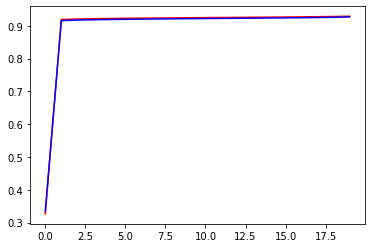

In [ ]:
#test = list(map(lambda x: x.item(),test))
#train = list(map(lambda x: x.item(),train))

plt.plot(list(range(int(len(train)))),train,color = 'red')
plt.plot(list(range(len(test))),test,color = 'blue')
plt.show()

In [ ]:
model.eval()
prev_i = 0
for img_,gt_ in zip(test_img,test_gt):
  predictions = model(img_.unsqueeze(0).to(device))
  predictions = torch.round(predictions)
  gts = torch.round(gt_)
  print(gts.shape)
  print('first set')
  print('acc: ')
  print((predictions.to('cpu')[0] == gts[0]).sum()/predictions.shape[2]**2)
  all_black_guess = torch.zeros(gts.shape)
  print((all_black_guess[0] == gts[0]).sum()/predictions.shape[2]**2)
  print()
  showImage(predictions.clone().to('cpu').detach(),gts,0,True)
  if prev_i == 3:
    break
  prev_i+=1


In [ ]:
model.eval()
torch.save(model,DATA_FOLDER+'basic_unet')



In [ ]:
train_img.max()

tensor(4.4466)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_loss))),train_loss,color = 'red',label = 'train_loss')
plt.plot(list(range(len(val_loss))),val_loss,color = 'blue',label = 'val_loss')
plt.legend()
plt.show()

NameError: ignored

tensor([[[0.8400, 0.8400, 0.8300,  ..., 0.7900, 0.8000, 0.8200],
         [0.8400, 0.8400, 0.8300,  ..., 0.8000, 0.8000, 0.8200],
         [0.8400, 0.8400, 0.8300,  ..., 0.7800, 0.8000, 0.8200],
         ...,
         [0.8100, 0.8100, 0.8100,  ..., 0.8600, 0.8500, 0.8500],
         [0.8000, 0.8000, 0.8100,  ..., 0.8600, 0.8500, 0.8500],
         [0.8100, 0.8100, 0.8200,  ..., 0.8700, 0.8600, 0.8600]]],
       device='cuda:0')

Mounted at /content/drive


test_1
test_2
test_3
test_4
test_5
test_6
test_7
test_8
test_9
test_10
test_11
test_12
test_13
test_14
test_15
test_16
test_17
test_18
test_19
test_20
test_21
test_22
test_23
test_24
test_25
test_26
test_27
test_28
test_29
test_30
test_31
test_32
test_33
test_34
test_35
test_36
test_37
test_38
test_39
test_40
test_41
test_42
test_43
test_44
test_45
test_46
test_47
test_48
test_49
test_50
torch.Size([50, 3, 608, 608])


In [ ]:
timg.std(),timg.mean()

(tensor(0.9967), tensor(-3.6853e-09))

In [ ]:
DATA_FOLDER

'/content/drive/MyDrive/ml/data/'

In [ ]:
from PIL import Image
prediction_dir = '/content/drive/MyDrive/ml/predictions/'


In [ ]:
for i in range(0,50):
  _,a = model(timg[i].unsqueeze(0).to(device)).to('cpu').detach()
  threshold = 0.25
  a[a >= threshold] = 1
  a[a < threshold] = 0
  a,_ = torch_to_numpy_format(a,torch.zeros(1,608,608))
  #if i < 9:
   # Image.fromarray(a[0,:,:,0].astype(np.uint8)).save(prediction_dir + "prediction_00" + str(i+1) + ".png")
  #else:
   # Image.fromarray(a[0,:,:,0].astype(np.uint8)).save(prediction_dir + "prediction_0" + str(i+1) + ".png")
  a[a > 0] = 255
  if i < 9 :
    Image.fromarray(a[0,:,:,0].astype(np.uint8)).save(prediction_dir + "prediction_00" + str(i+1) + ".png")
  else:
    Image.fromarray(a[0,:,:,0].astype(np.uint8)).save(prediction_dir + "prediction_0" + str(i+1) + ".png")


In [ ]:
a,v = load_images(TRAIN_IMAGES,GROUNDTRUTH_FOLDER,3,False)
v.shape

(3, 400, 400)

In [ ]:
a.shape

(3, 400, 400, 3)

In [ ]:
test_img.shape

torch.Size([120, 3, 400, 400])